In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 5.0MB/s 


In [2]:
from pyunpack import Archive

In [3]:
Archive('/content/drive/My Drive/Colab Notebooks/natural_images.rar').extractall('/content')

In [4]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import plot_model
import datetime 
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Activation, Dropout, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from os import listdir
from keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import glob
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

In [5]:
path = '/content/natural_images'

In [6]:
Images = {}
for folder in listdir(path):
  Images[folder] = len(listdir(path + '/' + folder))
Images

{'airplane': 727,
 'car': 968,
 'cat': 885,
 'dog': 702,
 'flower': 843,
 'fruit': 1000,
 'motorbike': 788,
 'person': 986}

In [7]:
PLOT = pd.DataFrame(Images.items(), columns = ['label', 'count'])
PLOT

label  count
0     flower    843
1        dog    702
2  motorbike    788
3        cat    885
4      fruit   1000
5        car    968
6   airplane    727
7     person    986

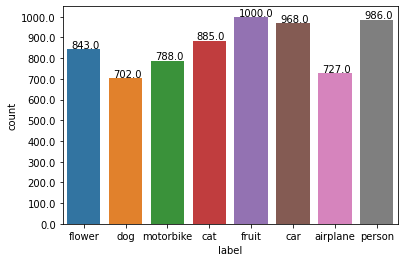

In [8]:
ax=sns.barplot(x = 'label', y = 'count', data = PLOT)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, max(PLOT['count']), 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{}'.format, ax.yaxis.get_majorticklocs()))
plt.show()

Sample Images
flower


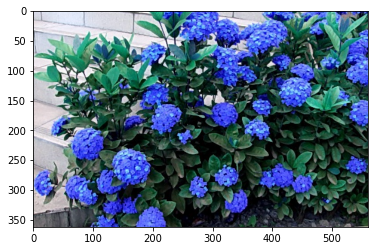

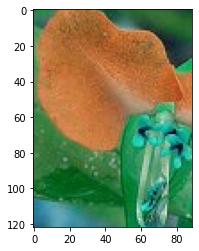

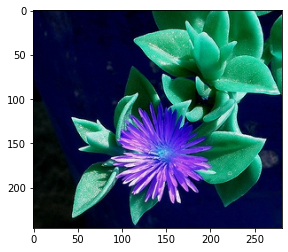

dog


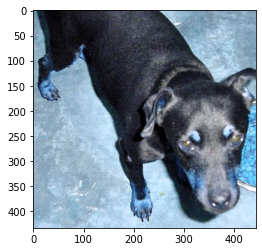

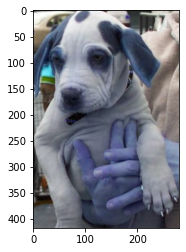

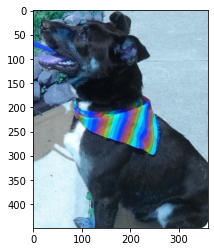

motorbike


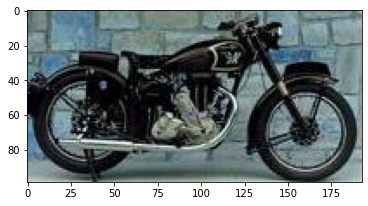

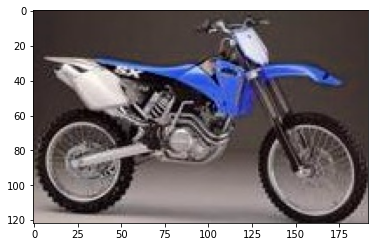

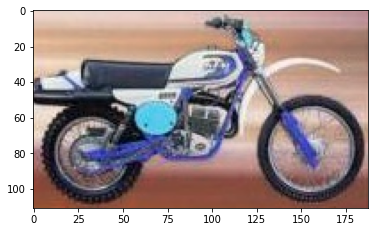

cat


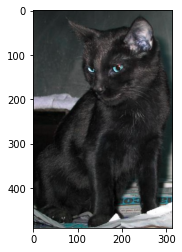

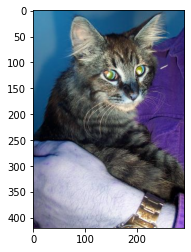

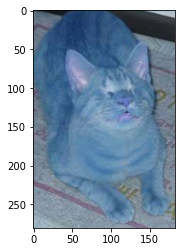

fruit


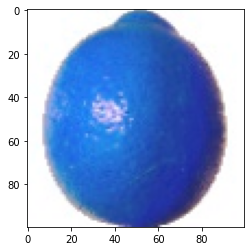

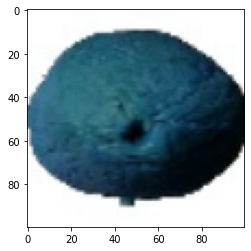

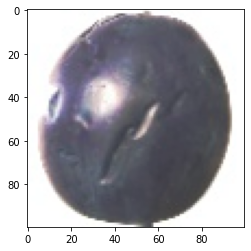

car


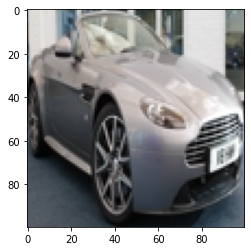

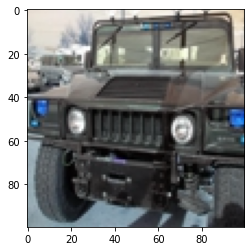

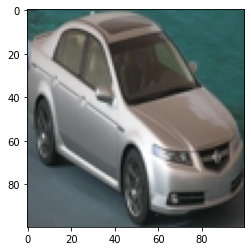

airplane


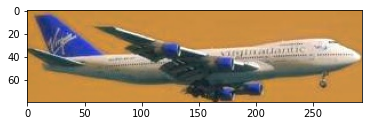

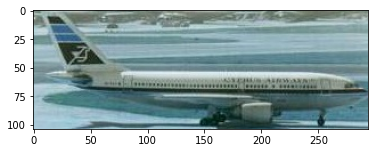

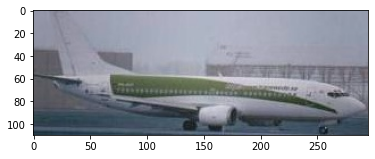

person


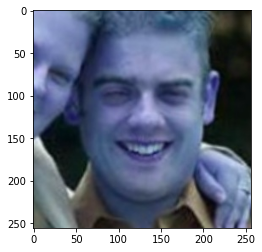

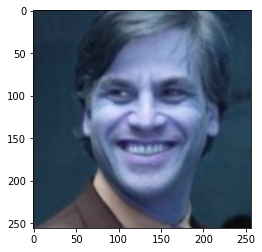

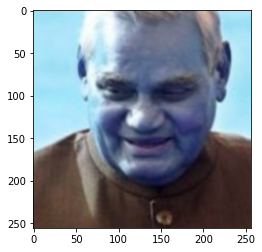

In [9]:
print('Sample Images')
for folder in listdir(path):
    c = 0
    print(folder)
    for file in listdir(path + '/' + folder):
        img = cv2.imread(path + '/' + folder + '/' + file)
        plt.imshow(img)
        plt.show()
        c += 1
        if(c == 3):
            break 

In [139]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

In [140]:
train_gen = data_gen.flow_from_directory(path, target_size = (224, 224), shuffle = True, batch_size = 32, class_mode='categorical', subset='training')

Found 5522 images belonging to 8 classes.


In [141]:
valid_gen = data_gen.flow_from_directory(path, target_size = (224, 224), shuffle = False, batch_size = 32, class_mode='categorical', subset='validation')

Found 1377 images belonging to 8 classes.


In [142]:
test = 'model_save/*.hdf5'
r = glob.glob(test)
for i in r:
    os.remove(i)

In [143]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
reducelr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 1, verbose = 1)

In [144]:
class LossHistory1(tf.keras.callbacks.Callback):
    
    def __init__(self, x = None, y = None):
        self.training_data = x 
        self.validation_data = y
    
    def on_train_begin(self, logs = {}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'train_f1_score': [], 'val_f1_score': []}

        
    def on_epoch_end(self, epoch, logs = {}):
        ## on end of each epoch, we will get logs and update the self.history dict
        train_predict =self.model.predict(self.training_data)
        train_bin = np.argmax(train_predict, axis = 1)
        train_targ = self.training_data.classes
        _train_f1 = f1_score(train_targ, train_bin, average = 'micro')
        #_train_auc = roc_auc_score(train_targ, train_predict)
         
        val_predict =self.model.predict(self.validation_data)
        val_bin = np.argmax(val_predict, axis = 1)
        val_targ = self.validation_data.classes
        _val_f1 = f1_score(val_targ, val_bin, average = 'micro')
        #_val_auc = roc_auc_score(val_targ, val_predict)
               
        self.history['val_f1_score'].append(_val_f1)
        self.history['train_f1_score'].append(_train_f1)
        
        print(' - train_f1_score : ', _train_f1, ' - val_f1_score : ', _val_f1)
        return

In [145]:
history_own = LossHistory1(train_gen, valid_gen)

In [146]:
callbacks = [checkpoint, reducelr]

In [147]:
tf.keras.backend.clear_session()

In [148]:
tf.keras.backend.clear_session()
base_model = MobileNet(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

In [149]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [150]:
for layer in base_model.layers:
  layer.trainable = False

In [151]:
layer1 = base_model.layers[-1].output

Pool1 = GlobalAveragePooling2D(name = 'Avg_Pool')(layer1)

#FC layer
FC1 = Dense(units=1024,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='FC1')(Pool1)
x = BatchNormalization()(FC1)
x = Dropout(0.35)(x)

#output layer
Out = Dense(units=8,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(x)


In [152]:
model = Model(inputs = base_model.inputs, outputs = Out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [153]:
for layer in model.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [154]:
optimizer = tf.keras.optimizers.Adam(0.01)

In [155]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', 'Recall', 'Precision'])

In [156]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

model.fit_generator(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15, callbacks = callbacks)

Epoch 1/15
172/172 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9423 - recall: 0.9404 - precision: 0.9449
Epoch 00001: val_accuracy improved from -inf to 0.94913, saving model to model_save/weights-01-0.9491.hdf5
172/172 [==============================] - 71s 411ms/step - loss: 0.2549 - accuracy: 0.9423 - recall: 0.9404 - precision: 0.9449 - val_loss: 0.4622 - val_accuracy: 0.9491 - val_recall: 0.9484 - val_precision: 0.9491
Epoch 2/15
172/172 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9621 - recall: 0.9619 - precision: 0.9626
Epoch 00002: val_accuracy improved from 0.94913 to 0.96439, saving model to model_save/weights-02-0.9644.hdf5
172/172 [==============================] - 70s 404ms/step - loss: 0.1668 - accuracy: 0.9621 - recall: 0.9619 - precision: 0.9626 - val_loss: 0.2082 - val_accuracy: 0.9644 - val_recall: 0.9637 - val_precision: 0.9651
Epoch 3/15
172/172 [==============================] - ETA: 0s - loss: 0.1454 - accura

In [157]:
model.save('final_model.hdf5')

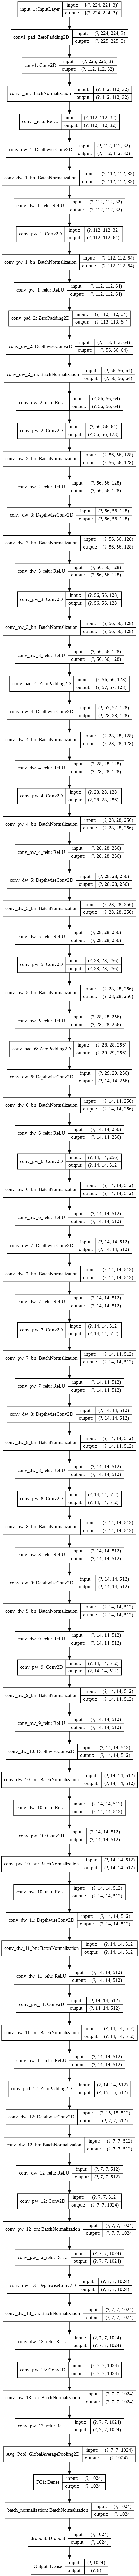

In [158]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [55]:
labels = list(train_gen.class_indices.keys())
labels

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

In [178]:
Y_pred = model.predict_generator(valid_gen, valid_gen.samples // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[142   0   0   1   1   0   1   0]
 [  1 192   0   0   0   0   0   0]
 [  0   0 172   5   0   0   0   0]
 [  0   0  11 127   1   0   1   0]
 [  0   0   1   0 167   0   0   0]
 [  0   0   0   0   0 200   0   0]
 [  0   0   0   0   0   0 157   0]
 [  0   0   0   0   0   0   0 197]]


In [175]:
print('Classification Report')
target_names = ['fruit', 'cat', 'airplane', 'flower', 'person', 'car', 'dog', 'motorbike']
print(classification_report(valid_gen.classes, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

    airplane       0.99      0.98      0.98       145
         car       0.99      1.00      0.99       193
         cat       0.93      0.97      0.95       177
         dog       0.95      0.90      0.92       140
      flower       1.00      0.99      0.99       168
       fruit       1.00      1.00      1.00       200
   motorbike       0.99      1.00      1.00       157
      person       1.00      0.99      1.00       197

    accuracy                           0.98      1377
   macro avg       0.98      0.98      0.98      1377
weighted avg       0.98      0.98      0.98      1377



[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'cat'),
 Text(0, 3.5, 'dog'),
 Text(0, 4.5, 'flower'),
 Text(0, 5.5, 'fruit'),
 Text(0, 6.5, 'motorbike'),
 Text(0, 7.5, 'person')]

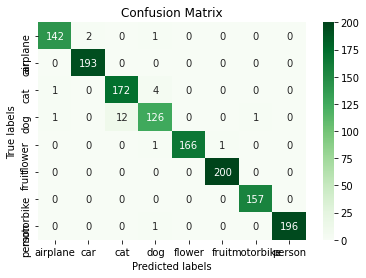

In [176]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(valid_gen.classes, y_pred), annot=True, ax = ax, fmt='g', cmap='Greens') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels)

In [163]:
import matplotlib.image as mpimg

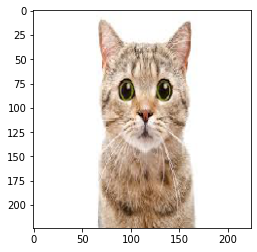

2
cat


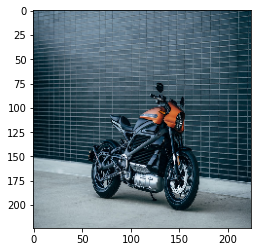

6
motorbike


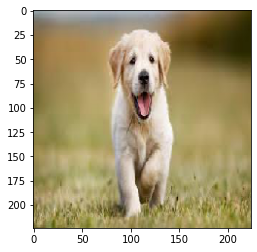

3
dog


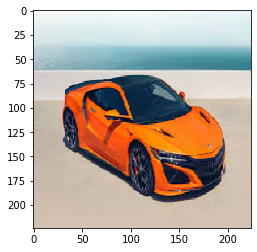

1
car


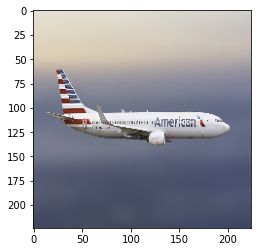

0
airplane


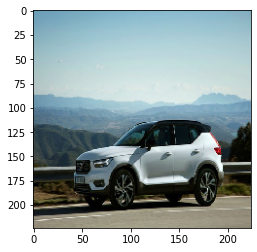

1
car


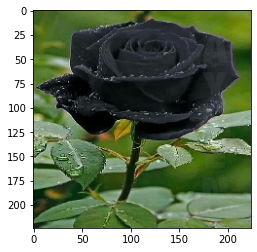

3
dog


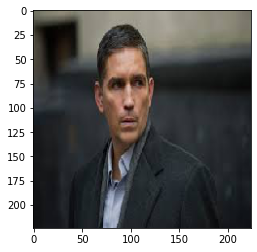

7
person


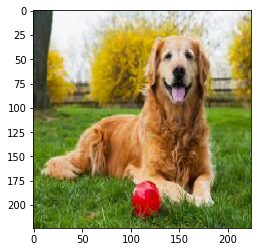

3
dog


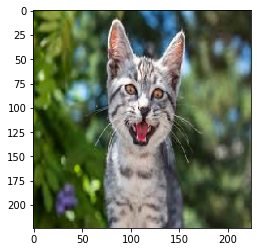

2
cat


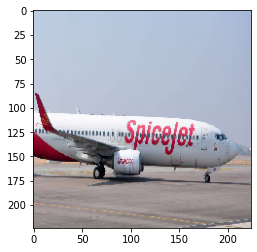

0
airplane


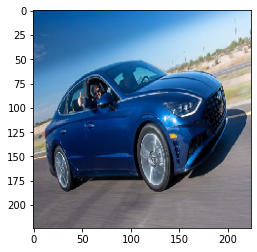

1
car


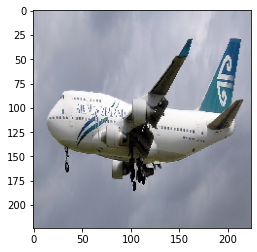

0
airplane


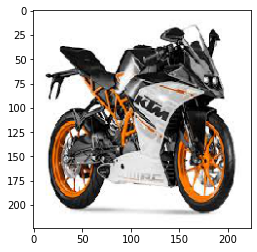

6
motorbike


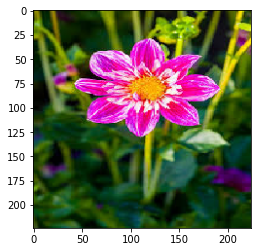

4
flower


In [172]:
for image in listdir('Test'):
    name = 'Test/' + image
    #img = mpimg.imread(name)
    image = tf.keras.preprocessing.image.load_img(name, target_size = (224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    plt.imshow(input_arr/255)
    plt.show()
    img = tf.expand_dims(input_arr, axis=0)
    img = preprocess_input(img)
    tp = model.predict(img)
    ind = int(np.argmax(tp, axis = 1))
    print(ind)
    print(labels[ind])

In [168]:
hg = ['cat/cat_0171.jpg',
 'cat/cat_0172.jpg',
 'cat/cat_0173.jpg',
 'cat/cat_0174.jpg',
 'cat/cat_0175.jpg',
 'cat/cat_0176.jpg',
 'dog/dog_0000.jpg',
 'dog/dog_0001.jpg',
 'dog/dog_0002.jpg',
 'dog/dog_0003.jpg',
 'dog/dog_0004.jpg',
 'dog/dog_0005.jpg',
 'airplane/airplane_0141.jpg',
 'airplane/airplane_0142.jpg',
 'airplane/airplane_0143.jpg',
 'airplane/airplane_0144.jpg',
 'car/car_0000.jpg',
 'car/car_0001.jpg',
 'car/car_0002.jpg',
 'car/car_0003.jpg']

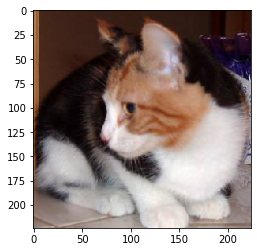

cat


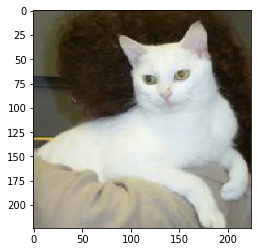

cat


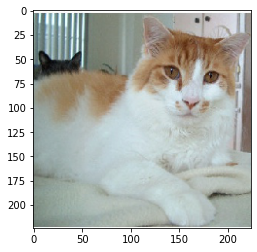

cat


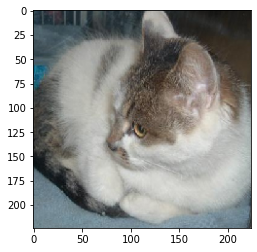

cat


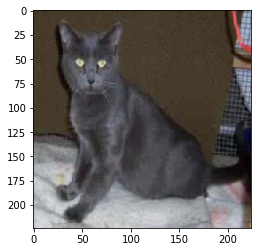

cat


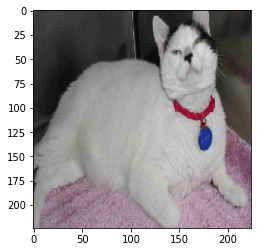

cat


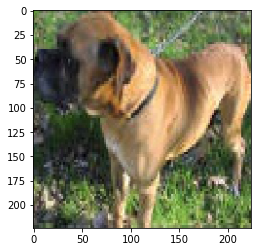

dog


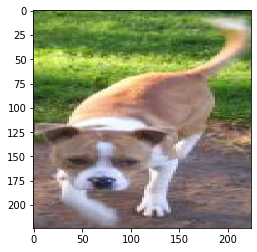

dog


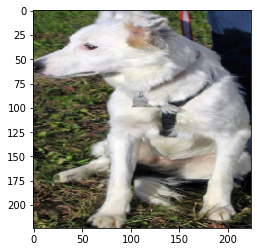

dog


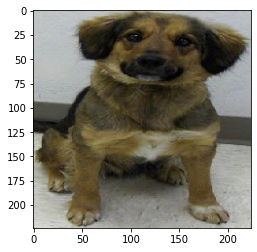

dog


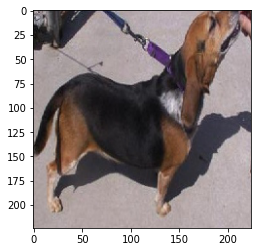

dog


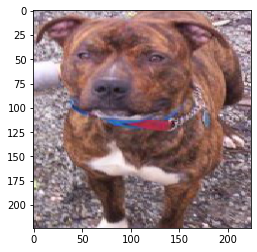

dog


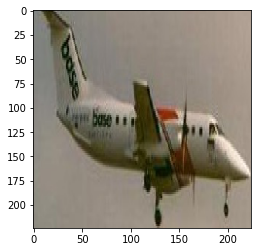

airplane


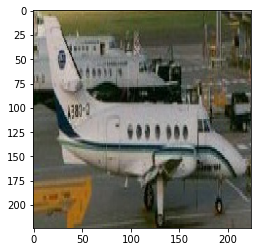

airplane


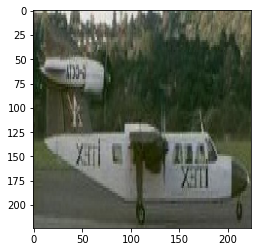

airplane


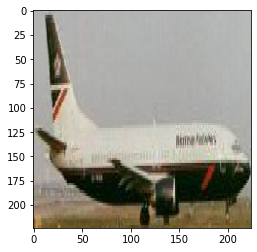

airplane


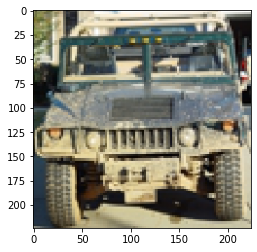

car


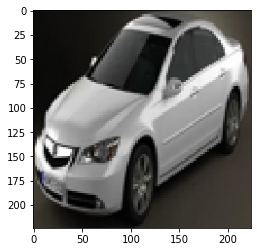

car


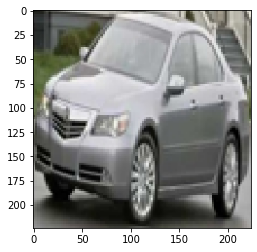

car


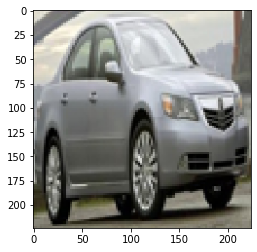

car


In [170]:
for image in hg:
    name = 'natural_images/' + image
    #img = mpimg.imread(name)
    image = tf.keras.preprocessing.image.load_img(name, target_size = (224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    plt.imshow(input_arr/255)
    plt.show()
    img = tf.expand_dims(input_arr, axis=0)
    img = preprocess_input(img)
    tp = model.predict(img)
    ind = int(np.argmax(tp[0]))
    print(labels[ind])

In [177]:
model = tf.keras.models.load_model('/content/final_model.hdf5')